In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import re
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


# # Function to load text data from folder
# def load_text_data(folder, label):
#     data = []
#     for filename in os.listdir(folder):
#         with open(os.path.join(folder, filename), 'r', encoding='utf-8') as file:
#             text = file.read()
#             data.append((text, label))
#     return data

# # Load positive and negative reviews
# positive_data = load_text_data('H:\\NLP Proj\\txt_sentoken\\pos', 'positive')
# negative_data = load_text_data('H:\\NLP Proj\\txt_sentoken\\neg', 'negative')

# # Merge positive and negative data
# merged_data = positive_data + negative_data

# # Create DataFrame
# df = pd.DataFrame(merged_data, columns=['review', 'sentiment'])

# # Save as CSV
# df.to_csv('H:\\Nlp\\merged_reviews.csv', index=False)

df = pd.read_csv('/content/merged_reviews.csv')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
# Label Encoding
label_encoder = LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])


In [ ]:
# Define a function to remove non-alphabetic characters from a string
def remove_non_alphabetic(text):
  return re.sub(r'[^a-zA-Z\s]', '', str(text))

# Apply the function to each cell in the DataFrame
df['review']  = df['review'].apply(remove_non_alphabetic)
df['review']


0       films adapted from comic books have had plenty...
1       every now and then a movie comes along from a ...
2       youve got mail works alot better than it deser...
3         jaws  is a rare film that grabs your attenti...
4       moviemaking is a lot like being the general ma...
                              ...                        
1995    if anything   stigmata  should be taken as a w...
1996    john boormans  zardoz  is a goofy cinematic de...
1997    the kids in the hall are an acquired taste  \n...
1998    there was a time when john carpenter was a gre...
1999    two party guys bob their heads to haddaways da...
Name: review, Length: 2000, dtype: object

In [ ]:
#function to filter the stopwords from my tokens
nwords = ["wasn","weren","shouldn","wasn","haven","musn","wouldn","not","hasn","wasn't","weren't","shouldn't","wasn't","haven't","musn't","wouldn't","hasn't","don't","don"]

def filter_stopwords(tokens):
  stop_words = set(stopwords.words('english'))
  stop_words = [word for word in stop_words if word not in nwords ]
  filtered_tokens = [token for token in tokens if token.lower() not in stop_words ]
  return filtered_tokens

In [ ]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun if no match

def lemmatize_text(text_list):
    lemmatizer = WordNetLemmatizer()
    lemmatized_list = []
    for word in text_list:
        # Get the POS tag for each word
        pos = pos_tag([word])[0][1]
        # Lemmatize the word using the appropriate POS tag
        lemmatized_word = lemmatizer.lemmatize(word, pos=get_wordnet_pos(pos))
        lemmatized_list.append(lemmatized_word)
    return lemmatized_list

# Tokenize the text
df['review'] = df['review'].apply(nltk.word_tokenize)

df['review'] = df['review'].apply(lemmatize_text)

df['review'] = df['review'].apply(filter_stopwords)

df['review']



0       [film, adapt, comic, book, plenty, success, wh...
1       [every, movie, come, along, suspect, studio, e...
2       [youve, get, mail, work, alot, well, deserves,...
3       [jaw, rare, film, grab, attention, show, singl...
4       [moviemaking, lot, like, general, manager, nfl...
                              ...                        
1995    [anything, stigma, take, warn, release, simila...
1996    [john, boormans, zardoz, goofy, cinematic, deb...
1997    [kid, hall, acquire, taste, take, least, seaso...
1998    [time, john, carpenter, great, horror, directo...
1999    [two, party, guy, bob, head, haddaways, dance,...
Name: review, Length: 2000, dtype: object

In [ ]:
# to find how many times words counts
temp_df = pd.Series(df['review']).value_counts()

df['review'] = df['review'].apply(lambda x: ' '.join(x))
df = df[df['review'] != '']

# choose the words with less than 2 frequencies to drop
drops = temp_df[temp_df <= 1]
df['review'] = df['review'].apply(lambda x: " ".join(x for x in x.split() if x not in drops))

# extract the term frequencies(frequency of the words) and create a df
tf = df["review"].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
tf.head()

,index,0
0,film,11111.0
1,hell,267.0
2,comic,389.0
3,say,1581.0
4,dont,1216.0


In [ ]:
# fix the column names
tf.columns = ["words", "tf"]

# to see the most frequent words
tf.sort_values("tf", ascending=False)

,words,tf
0,film,11111.0
367,movie,6857.0
139,one,5757.0
30,not,5674.0
15,make,4171.0
...,...,...
26206,outofchronologicalorder,1.0
26207,rigueur,1.0
26208,multiplots,1.0
26209,multiplot,1.0


In [ ]:
# word
tf_idf_word_vectorizer = TfidfVectorizer(min_df=0.05,max_df=0.9)
X_tf_idf_word = tf_idf_word_vectorizer.fit_transform(df['review'])
print(X_tf_idf_word.shape)

(2000, 990)


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X_tf_idf_word, df['sentiment'], test_size=0.2, shuffle=True,random_state=42)

In [ ]:
# Initialize the Logistic Regression classifier
logistic_regression_classifier = LogisticRegression(random_state=42)

# Train the Logistic Regression classifier
logistic_regression_classifier.fit(X_train, y_train)

y_train_pred = logistic_regression_classifier.predict(X_train)


# Predict labels for the test set
y_pred = logistic_regression_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate classification report
print("Classification Report:")
print(classification_report(y_train, y_train_pred))

Accuracy: 0.7875
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.76      0.78       201
           1       0.77      0.82      0.79       199

    accuracy                           0.79       400
   macro avg       0.79      0.79      0.79       400
weighted avg       0.79      0.79      0.79       400

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       799
           1       0.91      0.92      0.91       801

    accuracy                           0.91      1600
   macro avg       0.91      0.91      0.91      1600
weighted avg       0.91      0.91      0.91      1600



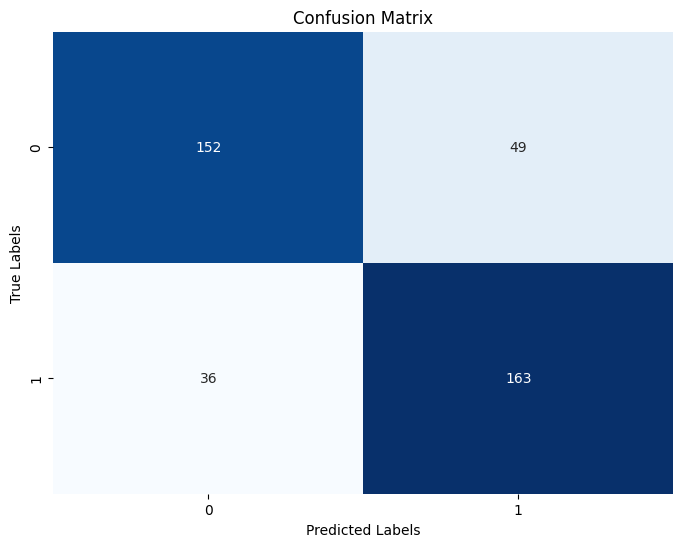

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Initialize the RandomForest classifier
random_forest_classifier = RandomForestClassifier(n_estimators=1000,max_depth = 5,min_samples_split=75 ,random_state=42,min_samples_leaf=50)

# Train the RandomForest classifier
random_forest_classifier.fit(X_train, y_train)

y_train_pred = random_forest_classifier.predict(X_train)
# Predict labels for the test set
y_pred = random_forest_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


# Generate classification report
print("Classification Report:")
print(classification_report(y_train, y_train_pred))

Accuracy: 0.7725
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.73      0.76       201
           1       0.75      0.81      0.78       199

    accuracy                           0.77       400
   macro avg       0.77      0.77      0.77       400
weighted avg       0.77      0.77      0.77       400

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.83      0.86       799
           1       0.84      0.89      0.86       801

    accuracy                           0.86      1600
   macro avg       0.86      0.86      0.86      1600
weighted avg       0.86      0.86      0.86      1600



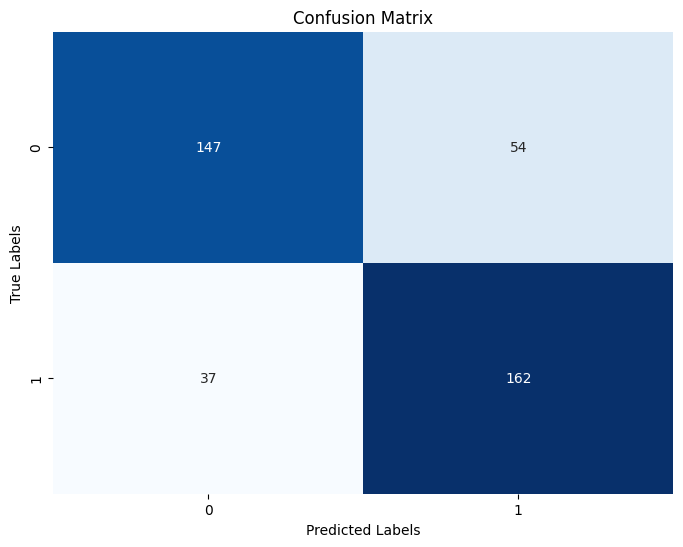

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Initialize the Naive Bayes classifier
naive_bayes_classifier = MultinomialNB()

# Train the Naive Bayes classifier
naive_bayes_classifier.fit(X_train, y_train)
y_train_pred = naive_bayes_classifier.predict(X_train)

# Predict labels for the test set
y_pred = naive_bayes_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate classification report
print("Classification Report:")
print(classification_report(y_train, y_train_pred))

Accuracy: 0.7625
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.78      0.77       201
           1       0.77      0.74      0.76       199

    accuracy                           0.76       400
   macro avg       0.76      0.76      0.76       400
weighted avg       0.76      0.76      0.76       400

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85       799
           1       0.86      0.84      0.85       801

    accuracy                           0.85      1600
   macro avg       0.85      0.85      0.85      1600
weighted avg       0.85      0.85      0.85      1600



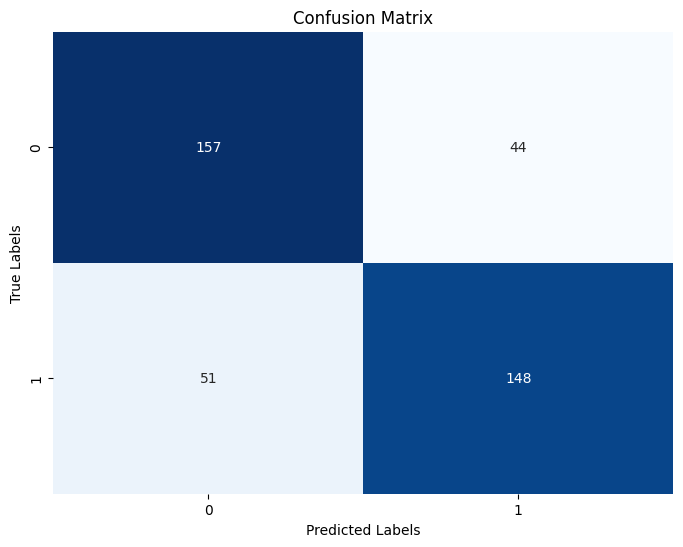

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()